# Remez

## Prelude

In [1]:
!pip install matplotlib numpy mpmath watermark

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [106]:
%matplotlib inline

import itertools
import math

import matplotlib
import numpy as np
from mpmath import mp
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, interactive, fixed, interact_manual

In [107]:
# Defaults more suitable for 4K monitors
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.figsize"] = [6.0, 4.0]
# Change font to match Latex
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'CMU Serif'
# Export settings
mpl.rcParams["savefig.bbox"] = 'tight'
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.facecolor"] = 'white'
# High compression lossless WebP for animations using ffmpeg -> libwebp
mpl.rcParams["animation.writer"] = 'ffmpeg'
mpl.rcParams["animation.codec"] = 'webp'
mpl.rcParams["animation.ffmpeg_args"] = ["-lossless", "1", "-qscale", "100"]
# Use anim.save("movie.webp", fps=60)

In [108]:
import watermark.watermark as watermark
print(watermark(machine=True, iso8601=True, python=True, iversions=True, globals_=globals()))

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.1.1

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

matplotlib: 3.5.1
numpy     : 1.22.1



## Utils

In [5]:
def zeros(x, y):
    i = np.where(np.diff(np.signbit(y)))[0]
    z = x[i]
    # TODO: Linear interpolation
    return z

In [6]:
def zeros_f(f, start, stop):
    x = np.linspace(start, stop, 1000)
    return zeros(x, f(x))

In [7]:
def max_error(start, stop, f, fi):
    x = np.linspace(start, stop, 1000)
    e = np.max(np.abs(f(x) - fi(x)))
    return e

In [162]:
def plot_approximation(start, stop, f, fi, nodes=None):
    xt = np.linspace(start, stop, 1000)
    yt = f(xt)
    yi = fi(xt)
    e = yi - yt
    el = np.min(e)
    eh = np.max(e)
    em = np.max(np.abs([el, eh]))
    print(f'Maximum absolute error: {em}')
    
    fig = plt.figure()
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212, sharex = ax1)

    ax1.set_title('Function approximation')
    ax1.plot(xt, yt, color='blue', label='truth')
    ax1.plot(xt, yi, color='orange', label='approximation')
    ax1.legend()
    
    ax2.set_title('Approximation error')
    ax2.plot(xt, e, color='red', label='error')
    ax2.axhline(0, color='black', linestyle='solid')
    ax2.axhline(-em, color='red', linestyle='dashed')
    ax2.axhline(em, color='red', linestyle='dashed')
    
    if nodes is None:
        nodes = zeros(xt, e)
    for x in nodes:
        ax1.axvline(x, color='gray', linestyle='dotted')
        ax2.axvline(x, color='gray', linestyle='dotted')

In [9]:
def vandermonde(x, n=None):
    if n is None:
        n = x.shape[0]
    V = np.vander(x, N=n, increasing=True)
    assert V.shape == (x.shape[0], n)
    return V

In [10]:
def interpolate_poly(x, y):
    V = vandermonde(x)
    c = np.linalg.solve(V, y)
    return c

In [11]:
def evaluate(coefficients, x):
    return np.polyval(np.flip(coefficients), x)

In [12]:
def poly_cond(start, stop, coefficients):
    x = np.linspace(start, stop, 1000)
    cond = evaluate(np.abs(coefficients), np.abs(x)) / np.abs(evaluate(coefficients, x))
    plt.plot(x, cond)
    cond = np.max(cond)
    print(f'Horner condition number: {cond}')
    return np.max(cond)

In [13]:
def fextrema(x, y):
    zi = np.where(np.diff(np.signbit(y)))[0]
    i = np.concatenate(([0],zi,[x.shape[0]]))
    i = [a + np.argmax(np.abs(y[a:b])) for (a,b) in zip(i[:-1], i[1:])]
    return (x[i], y[i])

In [14]:
def fancy_poly_plot(fi, nodes, file=None):
    x = equispaced_nodes(start, stop, 5)
    y = f(x)
    xt = np.linspace(-1.0, 4.0, 1000)
    yt = f(xt)

    fig, ax = plt.subplots()
    ax.plot(xt, yt, linewidth=1.0, color='black', linestyle='dashed')
    xt = np.linspace(0, 3, 1000)
    yt = f(xt)
    ax.plot(xt, yt, linewidth=1.0, color='black', linestyle='solid')
    ax.set_aspect('equal', 'box')

    ax.scatter(x,y, color='black')

    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    for s in ['top', 'right', 'left', 'bottom']:
        ax.spines[s].set_visible(False)

    if file:
        fig.savefig(file)

## Taylor expansion

NameError: name 'f' is not defined

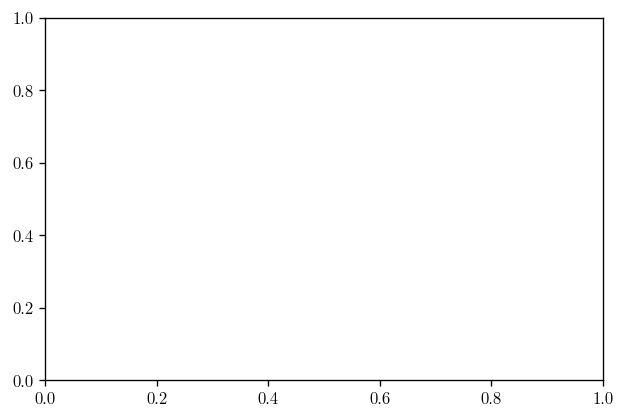

In [14]:
# Taylor
fi = lambda x: evaluate(coeff, x)

white = np.ones(3)
x = np.linspace(-4, 4, 1000)

fig, ax = plt.subplots(frameon=False)
ax.plot(x, f(x), color='black', linewidth=2.0, label='$e^{-x^2}$')
#ax.spines['left'].set_position('zero')

ax.set_aspect('equal', 'box')
ax.set_xlim(-3.2, 3.2)
ax.set_ylim(-0.2, 1.2)

ax.get_xaxis().set_ticks(range(-3,4), labels=['-3','','','0','','','3'])
ax.get_yaxis().set_visible(False)
for s in ['left', 'top', 'right']:
    ax.spines[s].set_visible(False)
ax.spines['bottom'].set_position('zero')

fig.savefig('func.png')

In [365]:
# Using Jax for autograd here only for the Taylor series example.
import jax
import jax.numpy as jnp

In [366]:
f = lambda x: jnp.exp(-x**2)
start, stop = -3, 3
num_p = 10

In [367]:
df = f
coeff = []
for i in range(num_p):
    coeff += [float(df(0.0))]
    df = jax.grad(df)
coeff

[1.0, -0.0, -2.0, 0.0, 12.0, -0.0, -120.0, 0.0, 1680.0, -0.0]

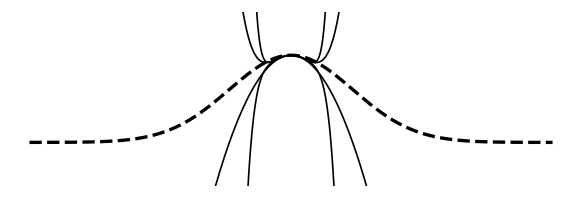

In [477]:
# Taylor
fi = lambda x: evaluate(coeff, x)

white = np.ones(3)
x = np.linspace(start, stop, 1000)

fig, ax = plt.subplots()
# ax.plot(x, evaluate([1], x), label='$1$', linewidth=1.0, color=0.0*white)
ax.plot(x, evaluate([1, 0, -2], x), label='$1-2x^2$', linewidth=1.0, color=0.0*white)
ax.plot(x, evaluate([1, 0, -2, 0, 12], x), label='$1-2x^2+12x^4$', linewidth=1.0, color=0.0*white)
ax.plot(x, evaluate([1, 0, -2, 0, 12, 0, -120], x), label='$1-2x^2+12x^4-120x^6$', linewidth=1.0, color=0.0*white)
ax.plot(x, evaluate([1, 0, -2, 0, 12, 0, -120, 0, 1680], x), label='$1-2x^2+12x^4-120x^6+1680x^8$', linewidth=1.0, color=0.0*white)

ax.set_ylim(-0.2, 1.2)
ax.get_xaxis().set_ticks(range(-3,4), labels=['-3','','','0','','','3'])
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)

ax.set_aspect('equal', 'box')
ax.set_xlim(-3.2, 3.2)
ax.set_ylim(-0.5, 1.5)

ax.plot(x, f(x), color='black', linewidth=2.0, label='$e^{-x^2}$', linestyle='dashed')

fig.savefig('taylor.png')

## Polynomial interpolation

In [15]:
f = lambda x: np.exp(x)
start, stop = 0.5, 0.5
num_p = 10

In [16]:
def equispaced_nodes(start, stop, n):
    return np.linspace(start, stop, n)

array([ 1.        , -0.14932125, -0.93296361,  0.55600104, -0.08848479])

Maximum absolute error: 0.036241146082295256


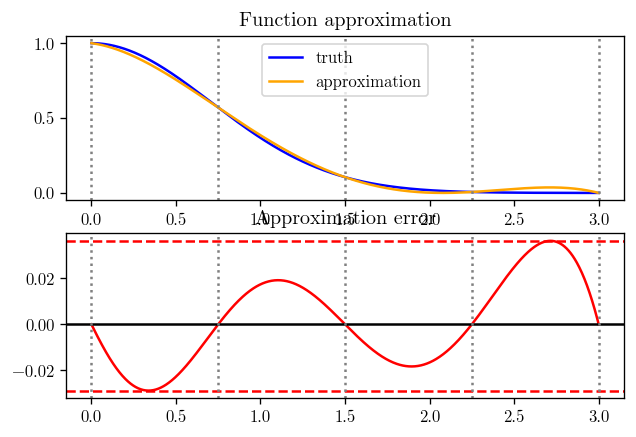

In [17]:
# Equispaced
x = equispaced_nodes(start, stop, 5)
y = f(x)
p = interpolate_poly(x, y)
fi = lambda x: evaluate(p, x)
display(p)

plot_approximation(start, stop, f, fi, nodes=x)
# poly_cond(0, 1, p)

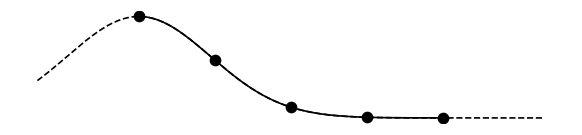

In [18]:
x = equispaced_nodes(start, stop, 5)
y = f(x)
p = interpolate_poly(x, y)
fi = lambda x: evaluate(p, x)

xt = np.linspace(-1.0, 4.0, 1000)
yt = f(xt)

fig, ax = plt.subplots()
ax.plot(xt, yt, linewidth=1.0, color='black', linestyle='dashed')
xt = np.linspace(0, 3, 1000)
yt = f(xt)
ax.plot(xt, yt, linewidth=1.0, color='black', linestyle='solid')
ax.set_aspect('equal', 'box')

ax.scatter(x,y, color='black')

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)
    

fig.savefig('equispaced.png')

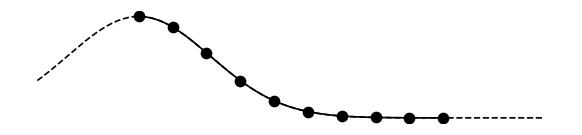

In [19]:
n = 10
xt = np.linspace(-1.0, 4.0, 1000)
yt = f(xt)

fig, ax = plt.subplots()
ax.plot(xt, yt, linewidth=1.0, color='black', linestyle='dashed')
ax.set_aspect('equal', 'box')


ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)
    
x = equispaced_nodes(0, 3, n)
y = f(x)
p = interpolate_poly(x, y)
fi = lambda x: evaluate(p, x)
ax.scatter(x,y, color='black')

xt = np.linspace(0, 3, 1000)
ax.plot(xt, fi(xt), linewidth=1.0, color='black', linestyle='solid')

fig.savefig(f'equispaced-{n}.png')



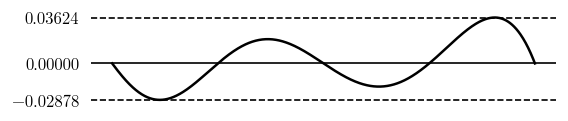

In [20]:
n = 5

fig, ax = plt.subplots(figsize=(5,1))

x = equispaced_nodes(0, 3, n)
y = f(x)
p = interpolate_poly(x, y)
fi = lambda x: evaluate(p, x)

xt = np.linspace(0, 3, 1000)
e = fi(xt) - f(xt)
ax.plot(xt, e, linewidth=1.5, color='black', linestyle='solid')

ax.axhline(0, color='black', linewidth=1.0, linestyle='solid')
ax.axhline(np.min(e), color='black', linewidth=1.0, linestyle='dashed')
ax.axhline(np.max(e), color='black', linewidth=1.0, linestyle='dashed')

ax.get_yaxis().set_ticks([np.min(e),0,np.max(e)])
ax.tick_params(axis="y", left=False)

ax.get_yaxis().set_visible(True)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)

fig.savefig(f'equispaced-{n}-err.png')


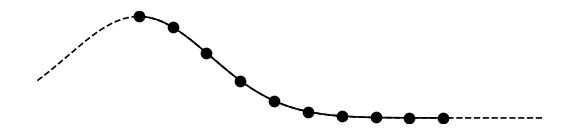

In [21]:
x = equispaced_nodes(start, stop, 10)
y = f(x)
p = interpolate_poly(x, y)
fi = lambda x: evaluate(p, x)

xt = np.linspace(-1.0, 4.0, 1000)
yt = f(xt)

fig, ax = plt.subplots()
ax.plot(xt, yt, linewidth=1.0, color='black', linestyle='dashed')
xt = np.linspace(0, 3, 1000)
yt = f(xt)
ax.plot(xt, yt, linewidth=1.0, color='black', linestyle='solid')
ax.set_aspect('equal', 'box')

ax.scatter(x,y, color='black')

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)
    

fig.savefig('equispaced-10.png')

In [22]:
def eval_equispaced(xt, num_p):
    x = equispaced_nodes(start, stop, num_p)
    y = f(x)
    p = interpolate_poly(x, y)
    return evaluate(p, xt)

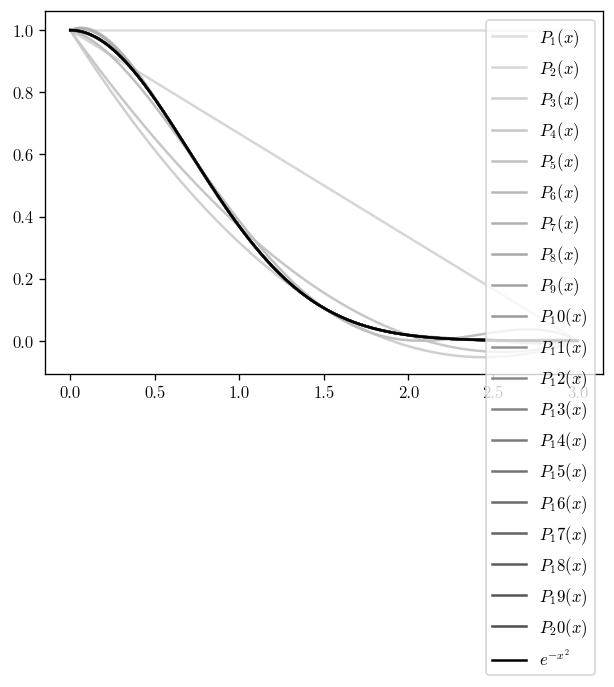

In [23]:
white = np.ones(3)
x = np.linspace(start, stop, 1000)
e_equispaced = []
for i in range(1,21):
    plt.plot(x, eval_equispaced(x, i), label=f'$P_{i}(x)$', color=(0.9-0.03*i)*white)
    e_equispaced += [max_error(start, stop, f, lambda x: eval_equispaced(x, i))]
plt.plot(x, f(x), color='black', label='$e^{-x^2}$')
plt.legend()

In [283]:
1 - 0.020767588287304906 / 0.026397680609342722

0.21327981065295576

## Chebyshev

In [24]:
def chebyshev_nodes(start, stop, n):
    f = (2 * np.arange(n) + 1) / (2 * n)
    z = -np.cos(np.pi * f) * 0.5 + 0.5
    x = start + (stop - start) * z
    return x

Maximum absolute error: 0.026397680609342722


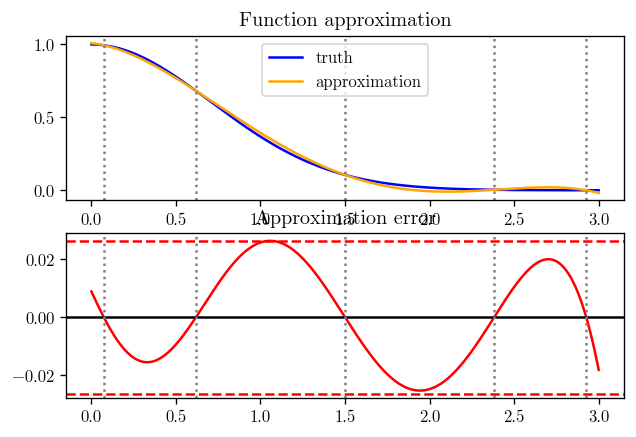

In [246]:
# Chebyshev
x = chebyshev_nodes(start, stop, 5)
y = f(x)
p = interpolate_poly(x, y)
fi = lambda x: evaluate(p, x)

plot_approximation(start, stop, f, fi, nodes=x)

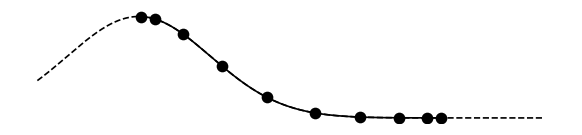

In [98]:
n = 10
xt = np.linspace(-1.0, 4.0, 1000)
yt = f(xt)

fig, ax = plt.subplots()
ax.plot(xt, yt, linewidth=1.0, color='black', linestyle='dashed')
ax.set_aspect('equal', 'box')


ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)
    
x = chebyshev_nodes(0, 3, n)
y = f(x)
p = interpolate_poly(x, y)
fi = lambda x: evaluate(p, x)
ax.scatter(x,y, color='black')

xt = np.linspace(0, 3, 1000)
ax.plot(xt, fi(xt), linewidth=1.0, color='black', linestyle='solid')

fig.savefig(f'chebyshev-{n}.png')


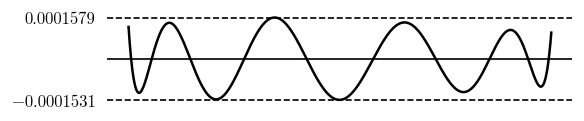

In [27]:
n = 10

fig, ax = plt.subplots(figsize=(5,1))

x = chebyshev_nodes(0, 3, n)
y = f(x)
p = interpolate_poly(x, y)
fi = lambda x: evaluate(p, x)

xt = np.linspace(0, 3, 1000)
e = fi(xt) - f(xt)
ax.plot(xt, e, linewidth=1.5, color='black', linestyle='solid')

ax.axhline(0, color='black', linewidth=1.0, linestyle='solid')
ax.axhline(np.min(e), color='black', linewidth=1.0, linestyle='dashed')
ax.axhline(np.max(e), color='black', linewidth=1.0, linestyle='dashed')

ax.get_yaxis().set_ticks([np.min(e),np.max(e)])
ax.tick_params(axis="y", left=False)

ax.get_yaxis().set_visible(True)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)

fig.savefig(f'chebyshev-{n}-err.png')


In [28]:
def eval_chebyshev(xt, num_p):
    x = chebyshev_nodes(start, stop, num_p)
    y = f(x)
    p = interpolate_poly(x, y)
    return evaluate(p, xt)

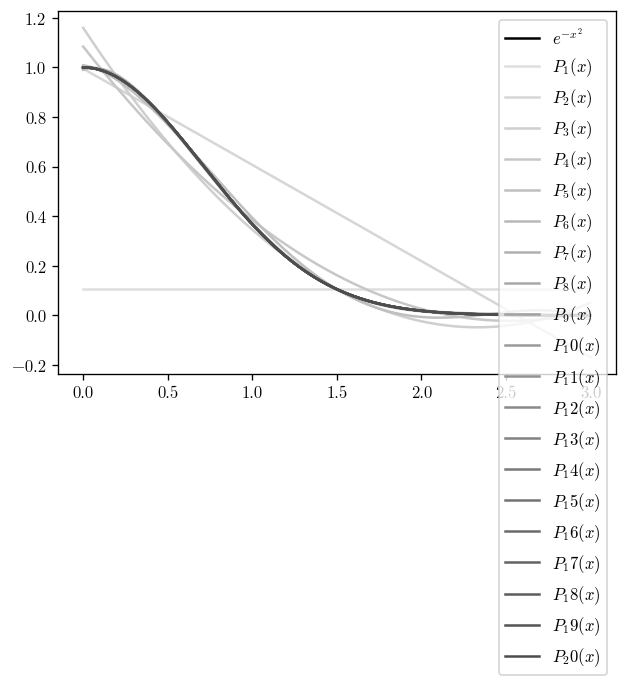

In [29]:
white = np.ones(3)
x = np.linspace(start, stop, 1000)
plt.plot(x, f(x), color='black', label='$e^{-x^2}$')
e_chebyshev = []
for i in range(1,21):
    plt.plot(x, eval_chebyshev(x, i), label=f'$P_{i}(x)$', color=(0.9-0.03*i)*white)
    e_chebyshev += [max_error(start, stop, f, lambda x: eval_chebyshev(x, i))]
plt.legend()

Maximum absolute error: 0.02128410415225379


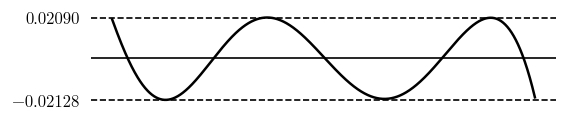

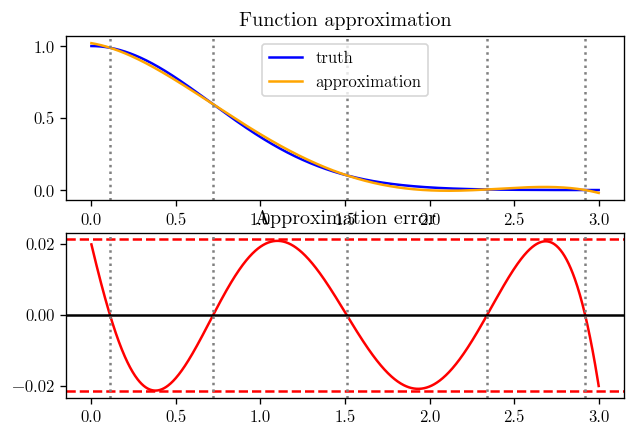

In [281]:
n = 5

fig, ax = plt.subplots(figsize=(5,1))

x = np.array([0.11, 0.72, 1.51, 2.34, 2.92])
y = f(x)
p = interpolate_poly(x, y)
fi = lambda x: evaluate(p, x)

plot_approximation(start, stop, f, fi, nodes=x)

xt = np.linspace(0, 3, 1000)
e = fi(xt) - f(xt)
ax.plot(xt, e, linewidth=1.5, color='black', linestyle='solid')

ax.axhline(0, color='black', linewidth=1.0, linestyle='solid')
ax.axhline(np.min(e), color='black', linewidth=1.0, linestyle='dashed')
ax.axhline(np.max(e), color='black', linewidth=1.0, linestyle='dashed')

ax.get_yaxis().set_ticks([np.min(e),np.max(e)])
ax.tick_params(axis="y", left=False)

ax.get_yaxis().set_visible(True)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)

fig.savefig(f'poly-manual-{n}-err.png')


## Remez

In [294]:
def winnow_extrema(x, y, n):
    best = None
    best_score = None
    for s in itertools.combinations(range(x.shape[0]), n):
        assert len(s) == n
        s = np.array(s)
        alternating = (np.diff(np.sign(y[s])) != 0).all()
        if not alternating:
            continue
        # score = np.max(np.abs(y[s])) - np.min(np.abs(y[s]))
        score = np.min(np.abs(y[s]))
        print(s, score)
        if best_score is None or score > best_score:
            best = s
            best_score = score
    if best is None:
        raise "Remez failed"
    return (x[best], y[best])

In [295]:
def remez_iter(start, stop, f, p, plot=True):
    Np = p.shape[0]
    
    # Find extrema of error
    fi = lambda x: evaluate(p, x)
    xt = np.linspace(start, stop, 1000)
    yt = f(xt)
    yi = fi(xt)
    e = yt - yi
    extrema, values = fextrema(xt, e)
    extrema, values = winnow_extrema(extrema, values, Np + 1)
    signs = np.sign(values)
    
    if plot:
        fig = plt.figure()
        ax = plt.subplot(111)
        ax.plot(xt, e, color='black')
        for (x, sign) in zip(extrema, signs):
            if sign < 0:
                plt.axvline(x, color='red', linestyle='dotted')
            else:
                plt.axvline(x, color='blue', linestyle='dotted')
    
    # Construct Remez matrix
    Vp = vandermonde(extrema, n=Np)
    Ve = signs[:,np.newaxis]
    V = np.hstack([Vp, Ve]) 
    y = f(extrema)
    pe = np.linalg.solve(V, y)
    p = pe[:Np]
    e = pe[Np]
    print(f'Solved error {e}')
    ye = f(extrema) - evaluate(p, extrema)
    return p

Maximum absolute error: 0.026397680609342722


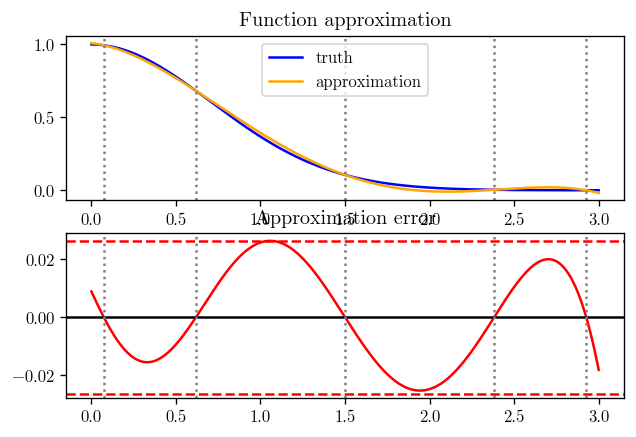

In [219]:
# Chebyshev
x = chebyshev_nodes(start, stop, 5)
y = f(x)
p = interpolate_poly(x, y)
fi = lambda x: evaluate(p, x)

plot_approximation(start, stop, f, fi, nodes=x)

Solved error 0.020544021265014985
Maximum absolute error: 0.02124056060971069


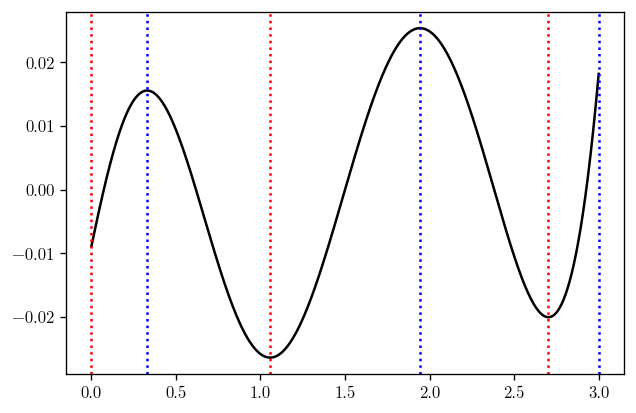

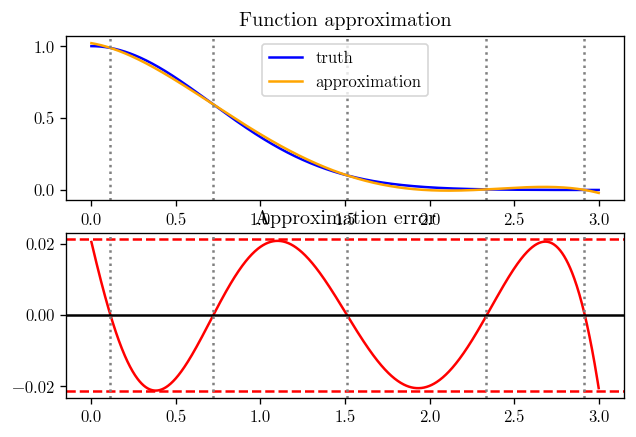

In [220]:
p1 = remez_iter(start, stop, f, p)

fi = lambda x: evaluate(p1, x)
plot_approximation(start, stop, f, fi)

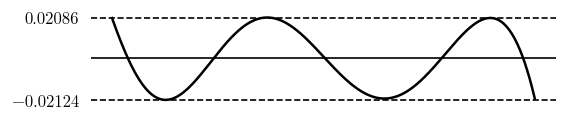

In [86]:
n = 5

fig, ax = plt.subplots(figsize=(5,1))

fi = lambda x: evaluate(p1, x)

xt = np.linspace(0, 3, 1000)
e = fi(xt) - f(xt)
ax.plot(xt, e, linewidth=1.5, color='black', linestyle='solid')

ax.axhline(0, color='black', linewidth=1.0, linestyle='solid')
ax.axhline(np.min(e), color='black', linewidth=1.0, linestyle='dashed')
ax.axhline(np.max(e), color='black', linewidth=1.0, linestyle='dashed')

ax.get_yaxis().set_ticks([np.min(e),np.max(e)])
ax.tick_params(axis="y", left=False)

ax.get_yaxis().set_visible(True)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)

fig.savefig(f'remez-{n}-1-iter-err.png')


In [91]:
1 - 0.02124056060971069 / 0.02640

0.1954333102382314

Solved error 0.020765676252477158
Maximum absolute error: 0.020767588287304906


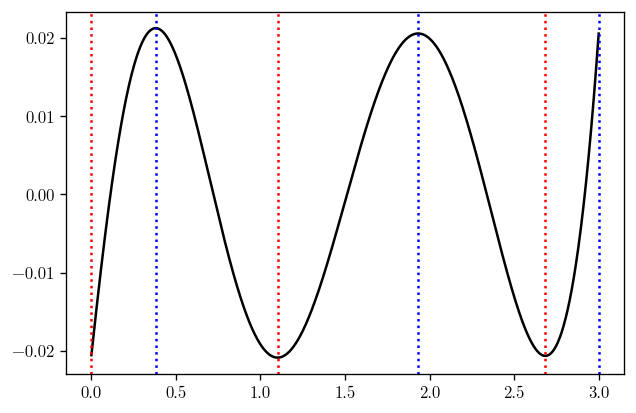

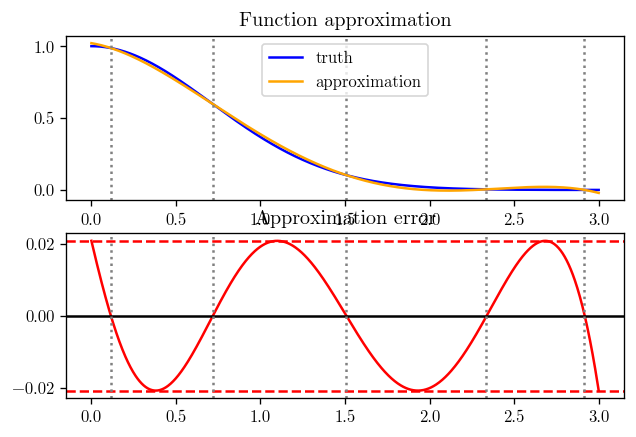

In [87]:
p2 = remez_iter(start, stop, f, p1)

fi = lambda x: evaluate(p2, x)
plot_approximation(start, stop, f, fi)

Solved error 0.02076612047545107
Maximum absolute error: 0.02076612047545199


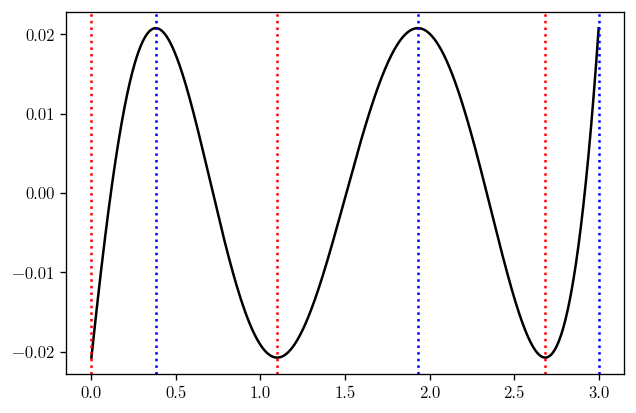

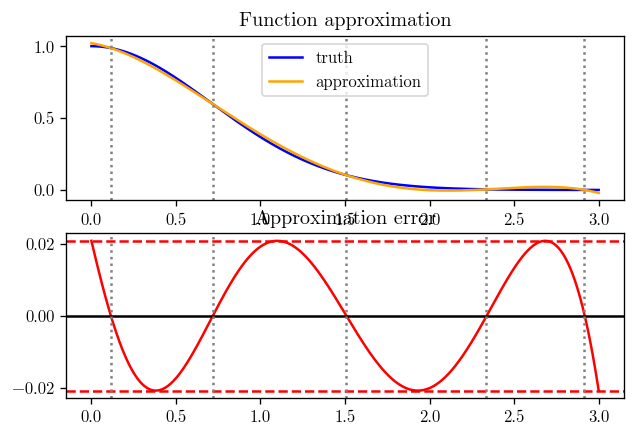

In [88]:
p3 = remez_iter(start, stop, f, p2)

fi = lambda x: evaluate(p3, x)
plot_approximation(start, stop, f, fi)

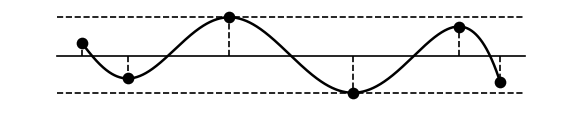

In [77]:
n = 5

fig, ax = plt.subplots(figsize=(6,1))

x = chebyshev_nodes(0, 3, n)
y = f(x)
p = interpolate_poly(x, y)
fi = lambda x: evaluate(p, x)

xt = np.linspace(0, 3, 1000)
e = fi(xt) - f(xt)
ax.plot(xt, e, linewidth=1.5, color='black', linestyle='solid')

ax.axhline(0, color='black', linewidth=1.0, linestyle='solid', xmin=0.08, xmax=0.92)
ax.axhline(np.min(e), color='black', linewidth=1.0, linestyle='dashed', xmin=0.08, xmax=0.92)
ax.axhline(np.max(e), color='black', linewidth=1.0, linestyle='dashed', xmin=0.08, xmax=0.92)

# Find extrema of error
fi = lambda x: evaluate(p, x)
xt = np.linspace(start, stop, 1000)
yt = f(xt)
yi = fi(xt)
e = yt - yi
extrema, values = fextrema(xt, e)
extrema, values = winnow_extrema(extrema, values, n + 1)
signs = np.sign(values)

ax.scatter(extrema, -values, color='black')
for (x, y) in zip(extrema, -values):
    ax.plot([x, x], [0, y], color='black', linewidth=1.0, linestyle='dashed')


ax.set_xlim(np.array([-0.5,3.5]))
ax.set_ylim(1.2*np.array([np.min(e), np.max(e)]))
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)

fig.savefig(f'remez-{n}-nodes.png')


## Polynomial approximation

In [35]:
def approx(f, start, stop, n=5, r=5, plot=True):
    # Initial Chebyshev approximation
    x = chebyshev_nodes(start, stop, n)
    y = f(x)
    p = interpolate_poly(x, y)
    if plot:
        fi = lambda x: evaluate(p, x)
        plot_approximation(start, stop, f, fi, nodes=x)
    
    # Remez optmization
    for i in range(r):
        p = remez_iter(start, stop, f, p, plot=plot)
        if plot:
            fi = lambda x: evaluate(p, x)
            plot_approximation(start, stop, f, fi)
    return p

Maximum absolute error: 0.026397680609342722
Solved error 0.020544021265014985
Maximum absolute error: 0.02124056060971069
Solved error 0.020765676252477158
Maximum absolute error: 0.020767588287304906
Solved error 0.02076612047545107
Maximum absolute error: 0.02076612047545199
Solved error 0.02076612047545107
Maximum absolute error: 0.02076612047545199
Solved error 0.02076612047545107
Maximum absolute error: 0.02076612047545199


array([ 1.02076612, -0.2001745 , -0.88298049,  0.53516136, -0.08572121])

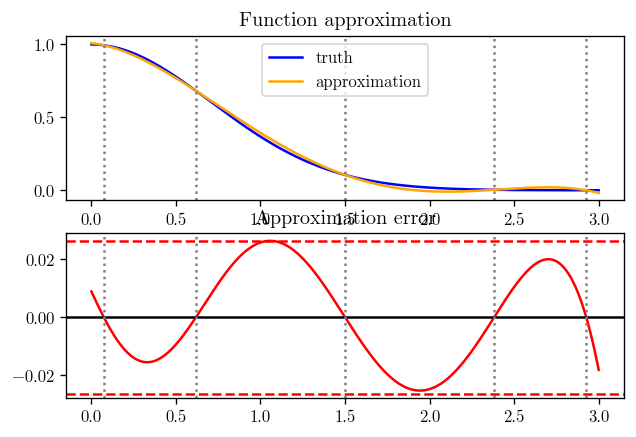

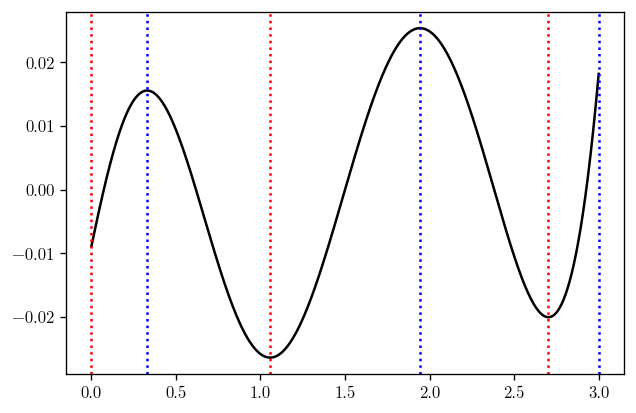

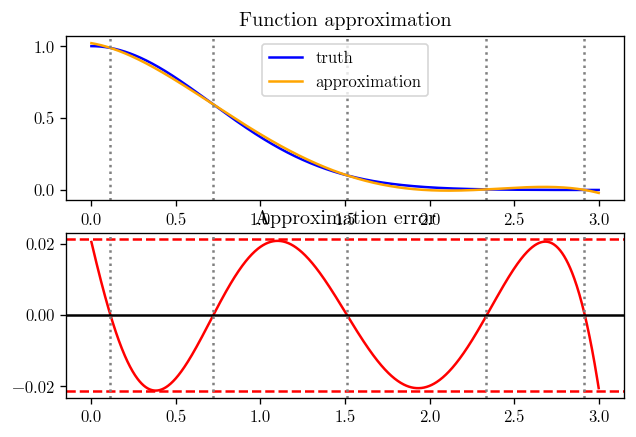

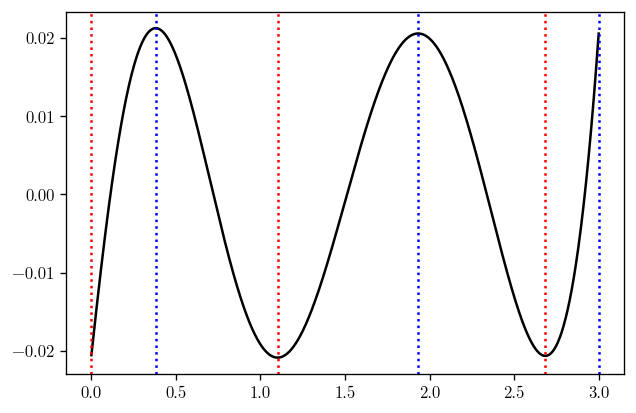

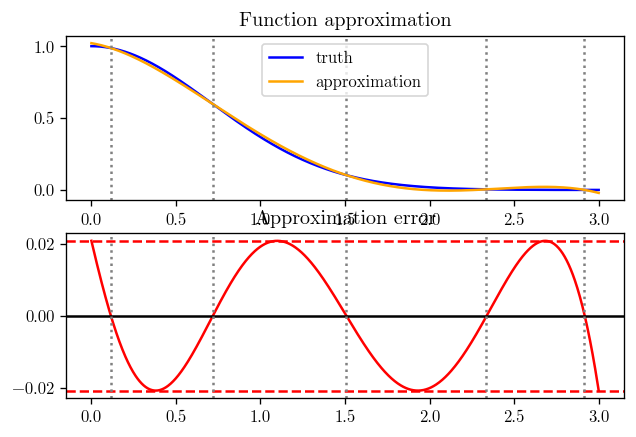

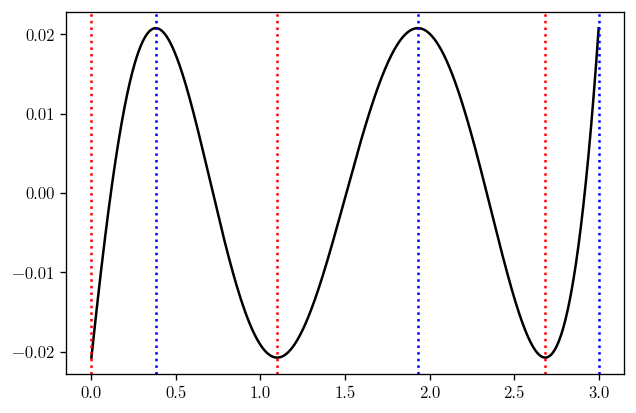

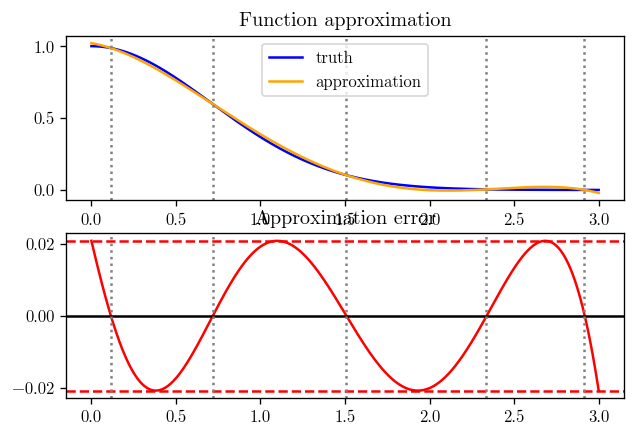

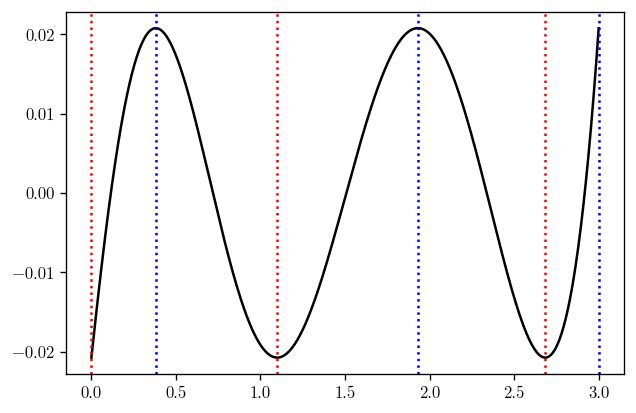

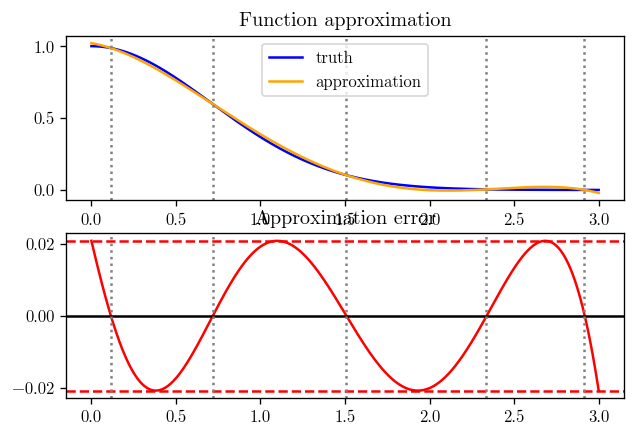

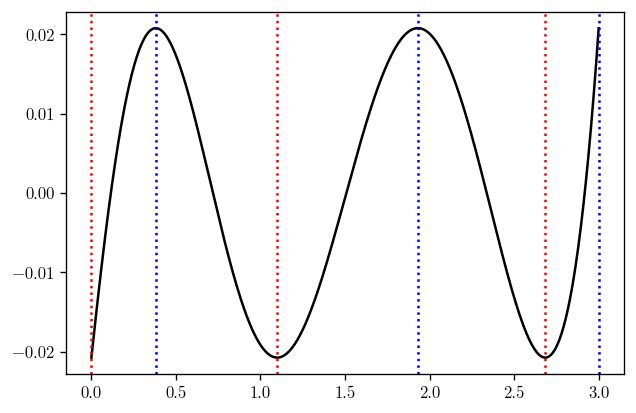

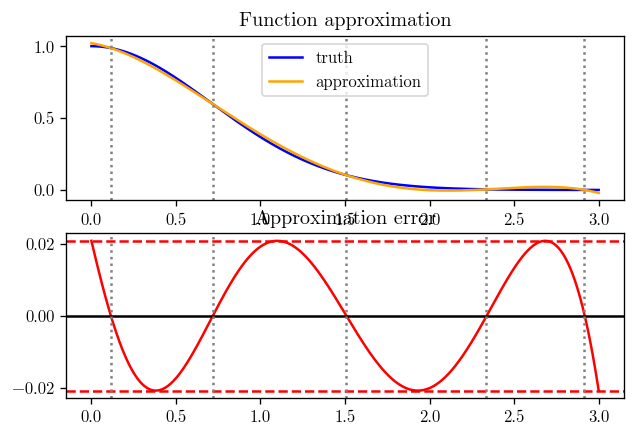

In [244]:
approx(f, start, stop, n=5)

Solved error 0.020544021265014985
Solved error 0.020765676252477158
Solved error 0.02076612047545107
Solved error 0.02076612047545107
Solved error 0.02076612047545107


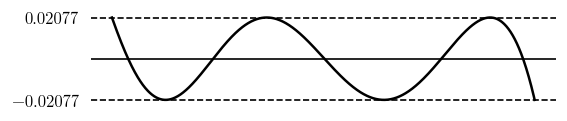

In [253]:
n = 5

fig, ax = plt.subplots(figsize=(5,1))

p = approx(f, start, stop, n=n, plot=False)
fi = lambda x: evaluate(p, x)

xt = np.linspace(0, 3, 1000)
e = fi(xt) - f(xt)
ax.plot(xt, e, linewidth=1.5, color='black', linestyle='solid')

ax.axhline(0, color='black', linewidth=1.0, linestyle='solid')
ax.axhline(np.min(e), color='black', linewidth=1.0, linestyle='dashed')
ax.axhline(np.max(e), color='black', linewidth=1.0, linestyle='dashed')

ax.get_yaxis().set_ticks([np.min(e),np.max(e)])
ax.tick_params(axis="y", left=False)

ax.get_yaxis().set_visible(True)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)

fig.savefig(f'remez-{n}-err.png')

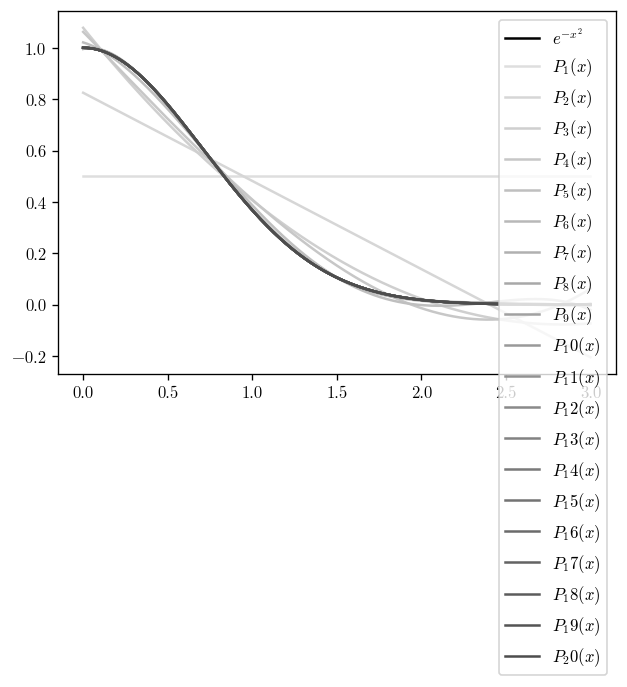

In [38]:
white = np.ones(3)
x = np.linspace(start, stop, 1000)
plt.plot(x, f(x), color='black', label='$e^{-x^2}$')
e_remez = []
for i in range(1,21):
    try:
        c = approx(f, start, stop, n=i, plot=False)
    except BaseException:
        print(i, "failed!")
        e_remez += [np.nan]
        continue
    fi = lambda x: evaluate(c, x)
    plt.plot(x, fi(x), label=f'$P_{i}(x)$', color=(0.9 - 0.03 * i) * white)
    e_remez += [max_error(start, stop, f, fi)]
plt.legend()

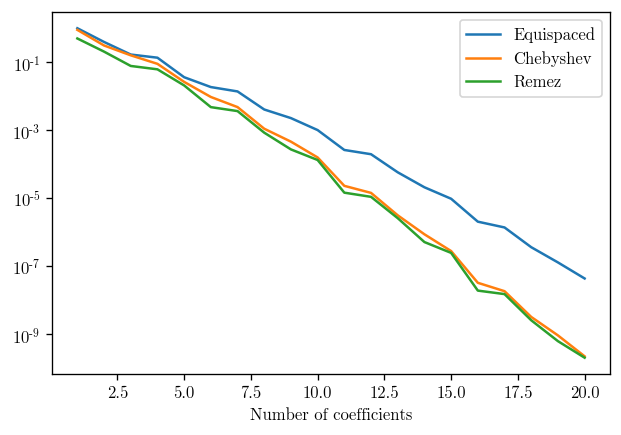

In [39]:
plt.plot(range(1,21), e_equispaced, label='Equispaced')
plt.plot(range(1,21), e_chebyshev, label='Chebyshev')
plt.plot(range(1,21), e_remez, label='Remez')

plt.yscale('log')
plt.xlabel('Number of coefficients')
plt.legend()

In [41]:
1 - 1.3/1.5

0.1333333333333333

## Rational

**To do:**

* Fix singularities due to zeros in denominator
* Fix the highest coefficient in denominator to be 1 instead of lowest (this should save a multiplication)

In [92]:
def evaluate_pade(coefficients, x):
    p = evaluate(coefficients[0], x)
    q = evaluate(coefficients[1], x)
    return p / q

In [93]:
def vandermonde_q(x, y, n):
    assert x.shape == y.shape
    Vq = vandermonde(x, n=n)
    ym = np.tile(-np.array(y)[:,np.newaxis], n)
    Vq = np.multiply(ym, Vq)
    assert Vq.shape == (x.shape[0], n)
    return Vq

In [205]:
def interpolate_pade(x, y, n):
    pn, qn = n
    assert x.shape == y.shape
    assert x.shape == (pn + qn - 1,)
    
    # Denominator coefficient to hold constant
    ci = 0
    cv = 1
    
    Vp = vandermonde(x, n=pn)
    Vq = vandermonde_q(x, y, n=qn)
    Vq = np.delete(Vq, ci, axis=1) # Delete column corresponding to constant
    V = np.hstack([Vp, Vq])
    yx = y * cv * x**ci
    r = np.linalg.solve(V, yx)
    p, q = r[:pn], r[pn:]
    q = np.insert(q, ci, cv)
    
    # Check for zeros in denominator
    xt = np.linspace(start, stop, 1000)
    yt = evaluate(q, xt)
    z = zeros(xt, yt)
    if len(z) > 0:
        print("Poles in Pade")
        # raise "Poles in Padé"
    
    return (p, q)

(array([ 1.00000000e+00, -6.05136384e-01, -3.65313758e-01,  3.31146884e-01,
         1.52621817e-02, -7.32361252e-02,  1.56432920e-02,  6.10424056e-03,
        -3.78751823e-03,  8.30291583e-04, -8.79326631e-05,  3.77633273e-06]),
 array([ 1.00000000e+00, -6.05136384e-01,  6.34686247e-01, -2.73989586e-01,
         1.49949309e-01, -4.46630961e-02,  1.49396872e-02, -2.48941078e-03,
         4.37703563e-04]))

Maximum absolute error: 9.861278460476797e-13


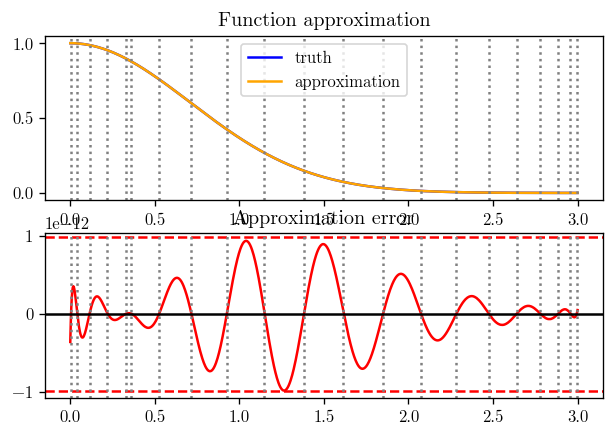

In [284]:
n = (12, 9)
x = chebyshev_nodes(start, stop, np.sum(n)-1)
y = f(x)
c = interpolate_pade(x, y, n)
display(c)

fi = lambda x: evaluate_pade(c, x)
plot_approximation(start, stop, f, fi)

In [ ]:
fig, ax = plt.subplots()

xt = np.linspace(-1.0, 4.0, 1000)
yt = f(xt)
ax.plot(xt, yt, linewidth=1.0, color='black', linestyle='dashed')
ax.set_aspect('equal', 'box')


ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)
    
x = chebyshev_nodes(start, stop, np.sum(n)-1)
y = f(x)
c = interpolate_pade(x, y, n)
display(c)
fi = lambda x: evaluate_pade(c, x)
ax.scatter(x, y, color='black')

xt = np.linspace(0, 3, 1000)
ax.plot(xt, fi(xt), linewidth=1.0, color='black', linestyle='solid')

ax.set_ylim([-0.5, 1.5])
fig.savefig(f'ratfn-{n[0]}-{n[1]}.png')


fig, ax = plt.subplots(figsize=(5,1))

e = fi(xt) - f(xt)
ax.plot(xt, e, linewidth=1.5, color='black', linestyle='solid')

ax.axhline(0, color='black', linewidth=1.0, linestyle='solid')
ax.axhline(np.min(e), color='black', linewidth=1.0, linestyle='dashed')
ax.axhline(np.max(e), color='black', linewidth=1.0, linestyle='dashed')

ax.get_yaxis().set_ticks([np.min(e),np.max(e)])
ax.tick_params(axis="y", left=False)

ax.get_yaxis().set_visible(True)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)

fig.savefig(f'ratfn-{n[0]}-{n[1]}-err.png')


Poles in Pade


(array([ 1.04506339, -1.58632468,  0.74871783, -0.11232492]),
 array([ 1.        , -0.84949604]))

1.177177177177177

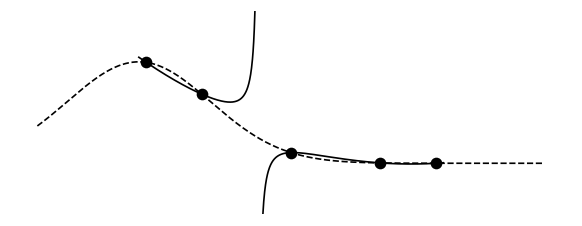

In [217]:
fig, ax = plt.subplots()

xt = np.linspace(-1.0, 4.0, 1000)
yt = f(xt)
ax.plot(xt, yt, linewidth=1.0, color='black', linestyle='dashed')
ax.set_aspect('equal', 'box')


ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)
    
x = chebyshev_nodes(start, stop, np.sum(n)-1)
y = f(x)
c = interpolate_pade(x, y, n)
display(c)
fi = lambda x: evaluate_pade(c, x)
ax.scatter(x, y, color='black')

xt = np.linspace(0, 3, 1000)
yt = fi(xt)
discont = np.argmin(yt)
display(xt[discont])
ax.plot(xt[:discont], yt[:discont], linewidth=1.0, color='black', linestyle='solid')
ax.plot(xt[discont:], yt[discont:], linewidth=1.0, color='black', linestyle='solid')

ax.set_ylim([-0.5, 1.5])
fig.savefig(f'ratfn-fail-{n[0]}-{n[1]}.png')

In [282]:
1.21 /1.16

1.043103448275862

In [218]:
1/0.84949604 

1.1771685245289667

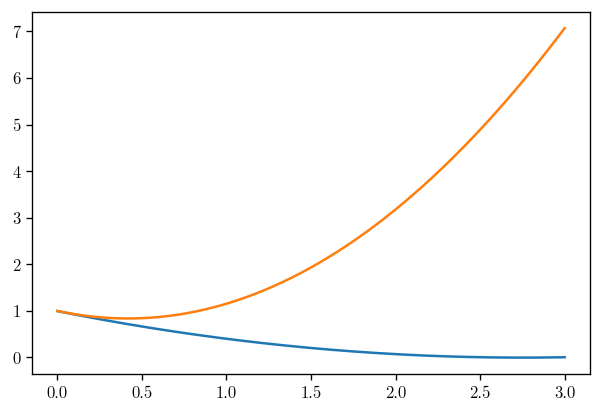

In [847]:
xt = np.linspace(start, stop, 1000)
plt.plot(xt, evaluate(c[0], xt))
plt.plot(xt, evaluate(c[1], xt))

In [1301]:
white = np.ones(3)
x = np.linspace(start, stop, 1000)
# plt.plot(x, f(x), color='black', label='$e^{-x^2}$')
e_pade = []
for i in range(1, 21):
    errs = []
    x = chebyshev_nodes(start, stop, i)
    y = f(x)
    for j in range(0, i):
        n = (i - j, j + 1)
        try:
            c = interpolate_pade(x, y, n)
        except:
            print(f'{n} failed')
            continue
        fi = lambda x: evaluate_pade(c, x)
        # plt.plot(x, fi(x), label=f'$P_{i,j}(x)$', color=(0.9 - 0.03 * i) * white)
        errs += [max_error(start, stop, f, fi)]
    e_pade += [np.min(errs)]

(1, 2) failed
(1, 3) failed
(2, 3) failed
(1, 4) failed
(4, 2) failed
(2, 4) failed
(1, 5) failed
(1, 6) failed
(1, 7) failed
(7, 2) failed
(5, 4) failed
(1, 8) failed
(1, 9) failed
(7, 4) failed
(5, 6) failed
(1, 10) failed
(10, 2) failed
(1, 11) failed
(12, 2) failed
(10, 4) failed
(8, 6) failed
(10, 6) failed
(8, 8) failed
(6, 10) failed
(15, 2) failed
(8, 10) failed
(6, 12) failed
(17, 2) failed
(15, 4) failed
(13, 6) failed
(6, 14) failed
(15, 6) failed
(13, 8) failed
(11, 10) failed


(array([ 1.00092238, -0.77861948,  0.15045445]),
 array([ 1.        , -0.70457657,  0.72795211]))

Maximum absolute error: 0.003682891280064715


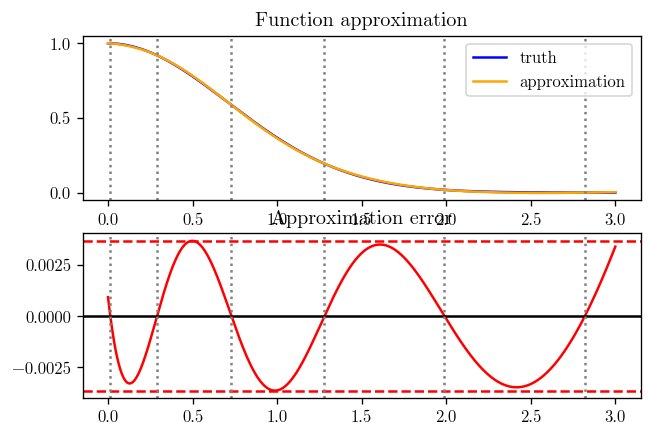

In [230]:
x = np.array([0.290, 0.730, 1.280, 1.990, 2.820])
y = f(x)
c = interpolate_pade(x, y, n)
display(c)

fi = lambda x: evaluate_pade(c, x)
plot_approximation(start, stop, f, fi)

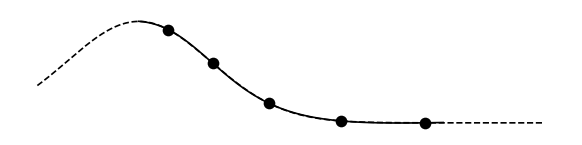

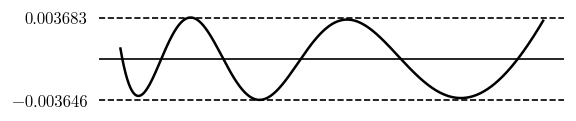

In [231]:
fig, ax = plt.subplots()

xt = np.linspace(-1.0, 4.0, 1000)
yt = f(xt)
ax.plot(xt, yt, linewidth=1.0, color='black', linestyle='dashed')
ax.set_aspect('equal', 'box')


ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)
    
x = np.array([0.290, 0.730, 1.280, 1.990, 2.820])
y = f(x)
c = interpolate_pade(x, y, n)
fi = lambda x: evaluate_pade(c, x)
ax.scatter(x, y, color='black')

xt = np.linspace(0, 3, 1000)
ax.plot(xt, fi(xt), linewidth=1.0, color='black', linestyle='solid')

ax.set_ylim([-0.1, 1.1])
fig.savefig(f'ratfn-manual-{n[0]}-{n[1]}.png')


fig, ax = plt.subplots(figsize=(5,1))

e = fi(xt) - f(xt)
ax.plot(xt, e, linewidth=1.5, color='black', linestyle='solid')

ax.axhline(0, color='black', linewidth=1.0, linestyle='solid')
ax.axhline(np.min(e), color='black', linewidth=1.0, linestyle='dashed')
ax.axhline(np.max(e), color='black', linewidth=1.0, linestyle='dashed')

ax.get_yaxis().set_ticks([np.min(e),np.max(e)])
ax.tick_params(axis="y", left=False)

ax.get_yaxis().set_visible(True)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)

fig.savefig(f'ratfn-manual-{n[0]}-{n[1]}-err.png')


## Remez Padé

In [285]:
def remez_pade_iter(start, stop, f, c, plot=False, e_tol=1e-5):
    pn = c[0].shape[0]
    qn = c[1].shape[0]
    
    fi = lambda x: evaluate_pade(c, x)
    xt = np.linspace(start, stop, 1000)
    yt = f(xt)
    yi = fi(xt)
    e = yi - yt
    extrema, values = fextrema(xt, e)
    extrema, values = winnow_extrema(extrema, values, pn + qn)
    signs = np.sign(values)
 
    if plot:
        plt.figure()
        plt.plot(xt, e, color='black')
        for (x, sign) in zip(extrema, signs):
            if sign < 0:
                plt.axvline(x, color='red', linestyle='dotted')
            else:
                plt.axvline(x, color='blue', linestyle='dotted')

    # Denominator coefficient to hold constant
    ci = 0
    cv = 1
 
    # Construct Remez matrix
    x = extrema
    y = f(x)
    Vp = vandermonde(x, n=pn)
    Ve = (-signs * cv * x**ci)[:,np.newaxis]
    yx = y * cv * x**ci
    
    def try_e(e):
        if e < 0:
            print('Error: error negative')
            # raise "Resulting error negative"
        Vq = vandermonde_q(x, y + e * signs, n=qn)
        Vq = np.delete(Vq, ci, axis=1) # Remove column for constant coefficient
        V = np.hstack([Vp, Vq, Ve])
        r = np.linalg.solve(V, yx)
        return r

    # Initially approximate errors using previous max error
    e = np.max(np.abs(e))
    
    # Iterate until the starting and computed error converge
    count = 0
    while True:
        r = try_e(e)
        er = r[-1]
        print(f'Starting error {e}, result error {er}') 
        if np.abs(er - e) / e < e_tol:
            break
        else:
            e = (e + er) / 2
        count += 1
        if count > 100:
            print('Error: e itteration did not converge')
            raise "Error itteration did not converge"
            break
    
    p, q, er = r[:pn], r[pn:-1], r[-1]
    q = np.insert(q, ci, cv) # Insert constant coefficient value
    c = (p, q)
    # ye = f(extrema) - evaluate_pade(c, extrema)
    # print(e, np.abs(ye))
    
    if plot:
        fi = lambda x: evaluate_pade(c, x)
        xt = np.linspace(start, stop, 1000)
        et = fi(xt) - f(xt)
        plt.figure()
        plt.plot(xt, et, color='black')
        plt.axhline(e, color='gray', linestyle='dashed')
        plt.axhline(-e, color='gray', linestyle='dashed')
        plt.axhline(er, color='red', linestyle='dashed')
        plt.axhline(-er, color='red', linestyle='dashed')
        for (x, sign) in zip(extrema, signs):
            if sign < 0:
                plt.axvline(x, color='red', linestyle='dotted')
            else:
                plt.axvline(x, color='blue', linestyle='dotted')
    
    # Check for zeros in denominator
    xt = np.linspace(start, stop, 1000)
    yt = evaluate(q, xt)
    z = zeros(xt, yt)
    if len(z) > 0:
        print('Error: resulting rational function has poles')
        raise "Poles in Padé (Remez)"

    return c

In [296]:
n = (12,9)

array([0.004624  , 0.04144512, 0.1141807 , 0.22103975, 0.35939105,
       0.52582793, 0.71625215, 0.92597485, 1.14983195, 1.38231136,
       1.61768864, 1.85016805, 2.07402515, 2.28374785, 2.47417207,
       2.64060895, 2.77896025, 2.8858193 , 2.95855488, 2.995376  ])

(array([ 1.00000000e+00, -6.05136384e-01, -3.65313758e-01,  3.31146884e-01,
         1.52621817e-02, -7.32361252e-02,  1.56432920e-02,  6.10424056e-03,
        -3.78751823e-03,  8.30291583e-04, -8.79326631e-05,  3.77633273e-06]),
 array([ 1.00000000e+00, -6.05136384e-01,  6.34686247e-01, -2.73989586e-01,
         1.49949309e-01, -4.46630961e-02,  1.49396872e-02, -2.48941078e-03,
         4.37703563e-04]))

Maximum absolute error: 9.861278460476797e-13


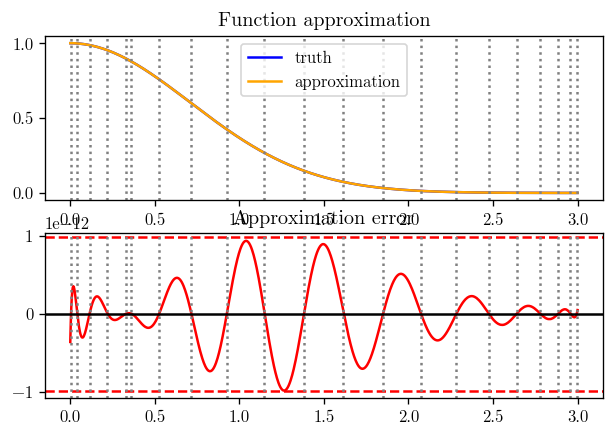

In [297]:
x = chebyshev_nodes(start, stop, np.sum(n) - 1)
display(x)
y = f(x)
c = interpolate_pade(x, y, n)
display(c)

fi = lambda x: evaluate_pade(c, x)
plot_approximation(start, stop, f, fi)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 5.440092820663267e-15
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 5.440092820663267e-15
Starting error 9.861278460476797e-13, result error 2.5335184859554313e-13
Starting error 6.197398473216114e-13, result error 2.4905046246920156e-13
Starting error 4.343951548954065e-13, result error 2.463521654442455e-13
Starting error 3.40373660169826e-13, result error 2.448523898046024e-13
Starting error 2.9261302498721417e-13, result error 2.440485320753231e-13
Starting error 2.6833077853126864e-13, result error 2.4362058930592664e-13
Starting error 2.5597568391859766e-13, result error 2.434392393512553e-13
Starting error 2.497074616349265e-13, result error 2.43302660442379e-13
Starting error 2.4650506103865277e-13, result error 2.432493481164705e-13
Starting error 2.4487720457756163e-13, result error 2.432327312090848e-13
Starting error 2.440549678933232e-13, result error 2.432257547805613e-13
Starting error 2.

(array([ 1.00000000e+00, -6.04946124e-01, -3.66166034e-01,  3.31569207e-01,
         1.55810864e-02, -7.35224727e-02,  1.56460653e-02,  6.17540141e-03,
        -3.82160752e-03,  8.37835708e-04, -8.87783766e-05,  3.81528885e-06]),
 array([ 1.00000000e+00, -6.04946124e-01,  6.33833970e-01, -2.73377001e-01,
         1.49415956e-01, -4.44322603e-02,  1.48366467e-02, -2.46613130e-03,
         4.32981562e-04]))

Maximum absolute error: 7.736844205661481e-13


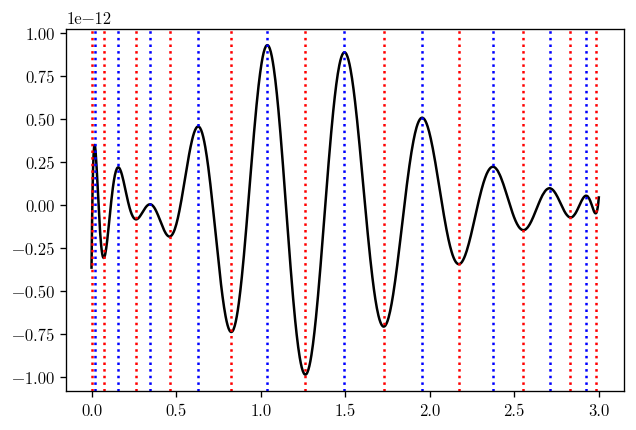

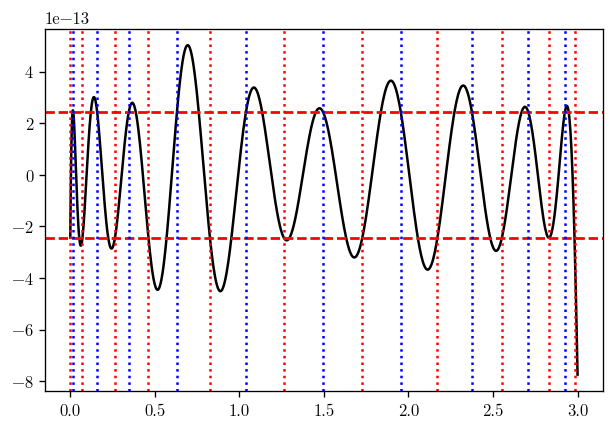

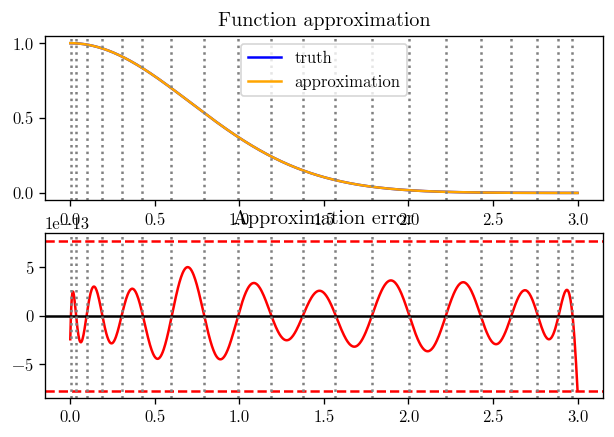

In [298]:
c1 = remez_pade_iter(start, stop, f, c, plot=True)
display(c1)

fi = lambda x: evaluate_pade(c1, x)
plot_approximation(start, stop, f, fi)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 2.432498646953718e-13
Starting error 7.736844205661481e-13, result error 3.065270607970372e-13
Starting error 5.401057406815927e-13, result error 3.1044432703093127e-13
Starting error 4.2527503385626197e-13, result error 3.1218425665082426e-13
Starting error 3.687296452535431e-13, result error 3.129972918034847e-13
Starting error 3.408634685285139e-13, result error 3.133960946539883e-13
Starting error 3.271297815912511e-13, result error 3.1360641254873304e-13
Starting error 3.2036809706999207e-13, result error 3.136859463412054e-13
Starting error 3.1702702170559873e-13, result error 3.13735403008196e-13
Starting error 3.1538121235689736e-13, result error 3.1374904063101993e-13
Starting error 3.145651264939586e-13, result error 3.1375583811124047e-13
Starting error 3.1416048230259957e-13, result error 3.1377160405310144e-13
Starting error 3.139660431778505e-13, result error 3.1377298080818194e-13
Starting error 3.138695119

(array([ 1.00000000e+00, -6.04817078e-01, -3.66453710e-01,  3.31659586e-01,
         1.57017353e-02, -7.36046956e-02,  1.56383697e-02,  6.20051966e-03,
        -3.83272989e-03,  8.40230916e-04, -8.90441144e-05,  3.82751275e-06]),
 array([ 1.00000000e+00, -6.04817078e-01,  6.33546295e-01, -2.73157585e-01,
         1.49249010e-01, -4.43599803e-02,  1.48070827e-02, -2.45960244e-03,
         4.31774193e-04]))

Maximum absolute error: 3.322814029135812e-13


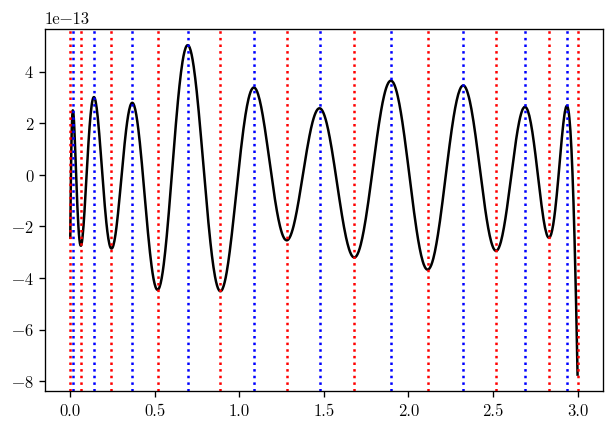

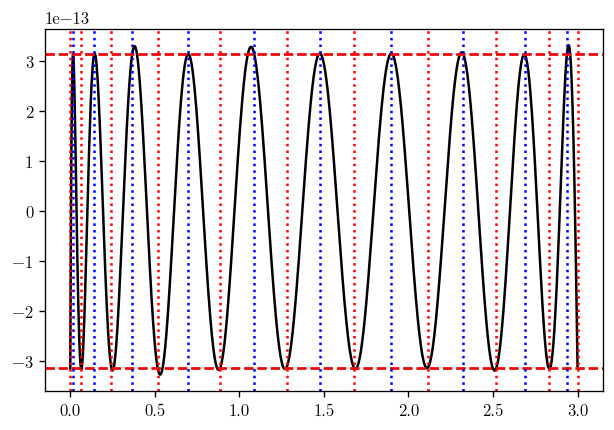

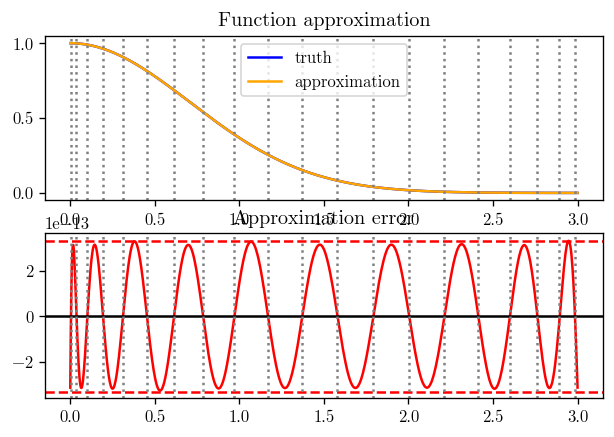

In [299]:
c2 = remez_pade_iter(start, stop, f, c1, plot=True)
display(c2)

fi = lambda x: evaluate_pade(c2, x)
plot_approximation(start, stop, f, fi)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 3.13360584225722e-13
Starting error 3.322814029135812e-13, result error 3.1802808671157234e-13
Starting error 3.251547448125768e-13, result error 3.180617499822418e-13
Starting error 3.2160824739740927e-13, result error 3.180844701626642e-13
Starting error 3.1984635878003673e-13, result error 3.1807630915359957e-13
Starting error 3.189613339668181e-13, result error 3.1807199636535776e-13
Starting error 3.1851666516608796e-13, result error 3.180788062569166e-13
Starting error 3.182977357115023e-13, result error 3.180861588189774e-13
Starting error 3.181919472652398e-13, result error 3.180840309988313e-13
Starting error 3.1813798913203557e-13, result error 3.1808197771162146e-13
Starting error 3.181099834218285e-13, result error 3.1807697604163735e-13
Starting error 3.180934797317329e-13, result error 3.1807537593156097e-13
Starting error 3.1808442783164696e-13, result error 3.1807931299491725e-13
Starting error 3.180818704

(array([ 1.00000000e+00, -6.04804677e-01, -3.66460738e-01,  3.31654514e-01,
         1.57060157e-02, -7.36044420e-02,  1.56372956e-02,  6.20089078e-03,
        -3.83276272e-03,  8.40223108e-04, -8.90421034e-05,  3.82737936e-06]),
 array([ 1.00000000e+00, -6.04804677e-01,  6.33539267e-01, -2.73150257e-01,
         1.49246265e-01, -4.43586147e-02,  1.48068214e-02, -2.45954165e-03,
         4.31777318e-04]))

Maximum absolute error: 3.1999403127258574e-13


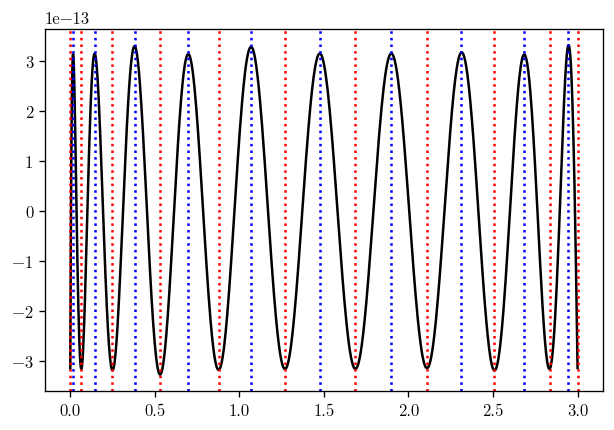

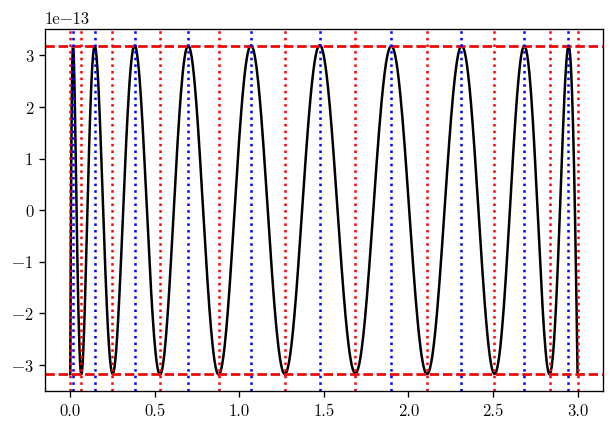

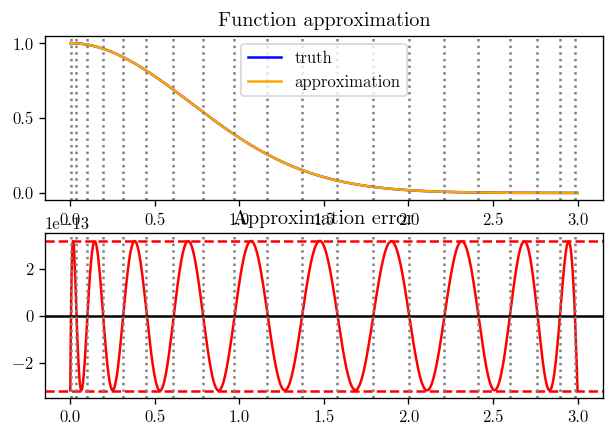

In [300]:
c3 = remez_pade_iter(start, stop, f, c2, plot=True)
display(c3)

fi = lambda x: evaluate_pade(c3, x)
plot_approximation(start, stop, f, fi)

## Automate

In [124]:
nudges = {
    (4,3): 1.5,
    (2,5): 1.5, # Fails
    (5,14): 1.4
}

In [125]:
def approx_pade(f, start, stop, n=(3,3), r=5, plot=False):
    # Initial Chebyshev approximation
    x = chebyshev_nodes(start, stop, np.sum(n)-1)
    if n in nudges:
        # Nudge points to the left
        x = 3 * (x / 3)**nudges[n]
    y = f(x)
    p = interpolate_pade(x, y, n)
    if plot:
        fi = lambda x: evaluate_pade(p, x)
        plot_approximation(start, stop, f, fi, nodes=x)
    
    # Remez optmization
    for i in range(r):
        try:
            p = remez_pade_iter(start, stop, f, p, plot=plot)
        except:
            print(f'Remez failed after {i}')
            break
        if plot:
            fi = lambda x: evaluate_pade(p, x)
            plot_approximation(start, stop, f, fi)
    return p

Maximum absolute error: 9.861278460476797e-13
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 5.440092820663267e-15
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 5.440092820663267e-15
Starting error 9.861278460476797e-13, result error 2.5335184859554313e-13
Starting error 6.197398473216114e-13, result error 2.4905046246920156e-13
Starting error 4.343951548954065e-13, result error 2.463521654442455e-13
Starting error 3.40373660169826e-13, result error 2.448523898046024e-13
Starting error 2.9261302498721417e-13, result error 2.440485320753231e-13
Starting error 2.6833077853126864e-13, result error 2.4362058930592664e-13
Starting error 2.5597568391859766e-13, result error 2.434392393512553e-13
Starting error 2.497074616349265e-13, result error 2.43302660442379e-13
Starting error 2.4650506103865277e-13, result error 2.432493481164705e-13
Starting error 2.4487720457756163e-13, result error 2.432327312090848e-13
Starting error 2.440549678933232e-13, result

(array([ 1.00000000e+00, -6.04804332e-01, -3.66461840e-01,  3.31654978e-01,
         1.57064561e-02, -7.36047939e-02,  1.56372806e-02,  6.20099108e-03,
        -3.83280932e-03,  8.40233396e-04, -8.90432648e-05,  3.82743351e-06]),
 array([ 1.00000000e+00, -6.04804333e-01,  6.33538165e-01, -2.73149448e-01,
         1.49245605e-01, -4.43583314e-02,  1.48067008e-02, -2.45951509e-03,
         4.31772184e-04]))

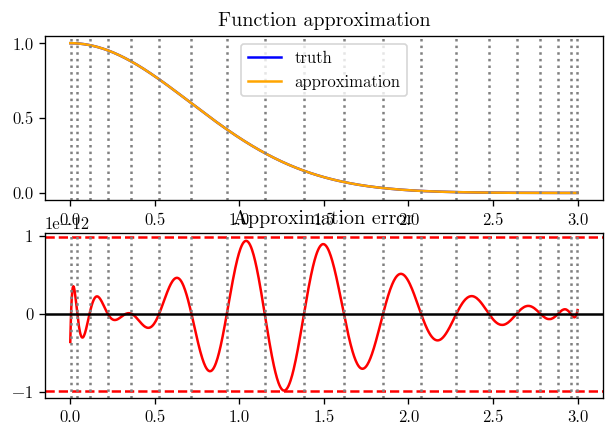

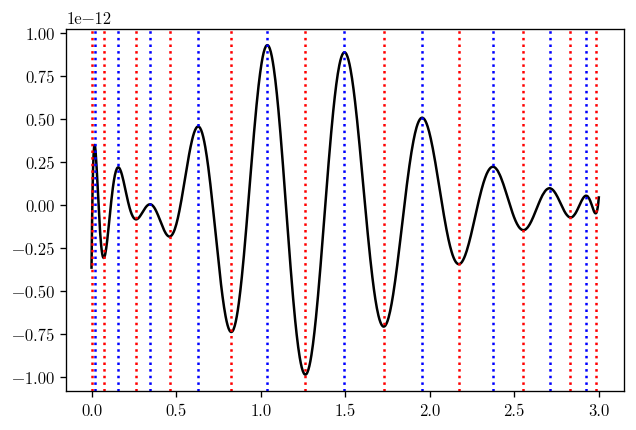

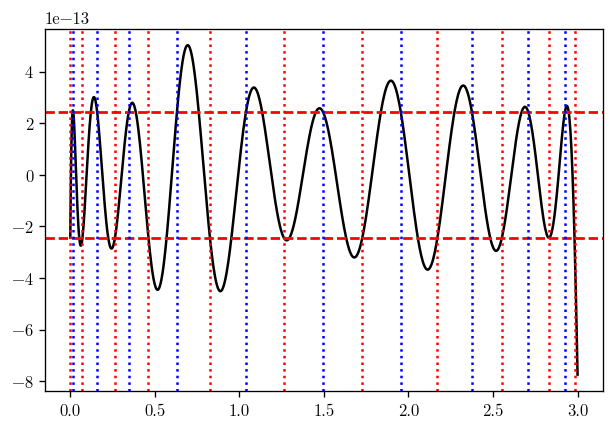

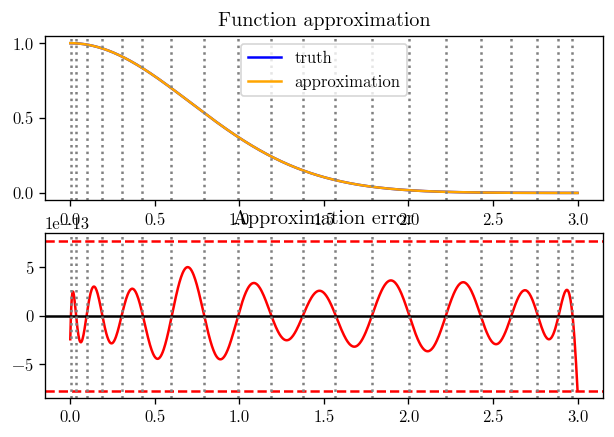

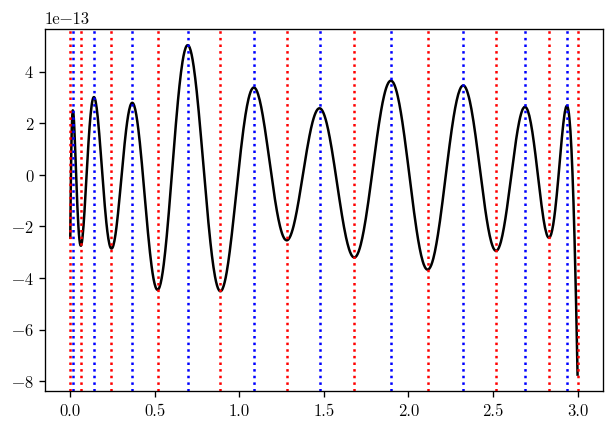

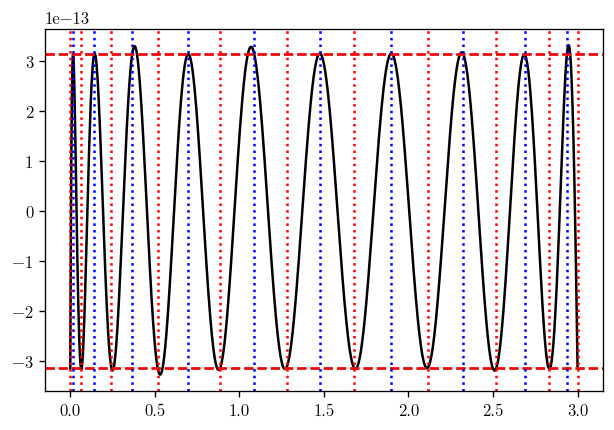

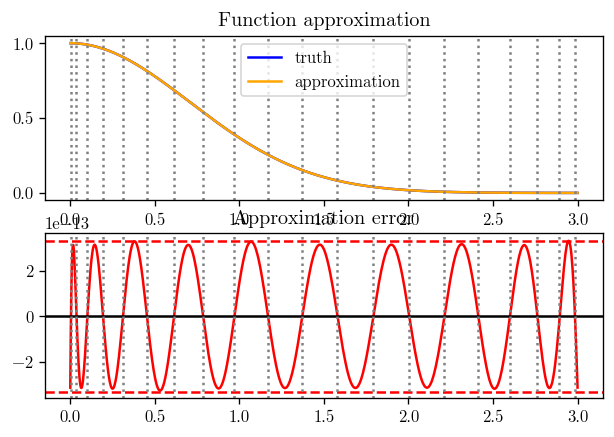

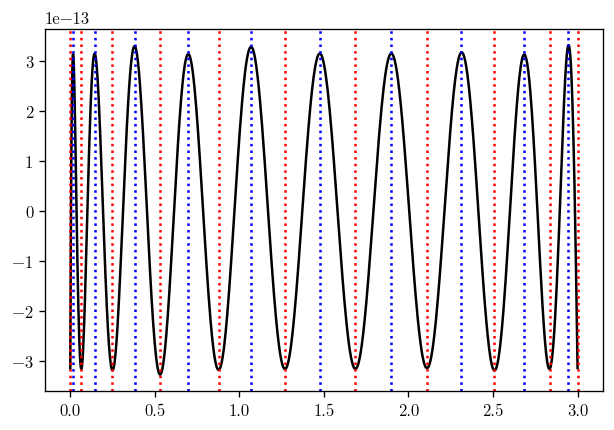

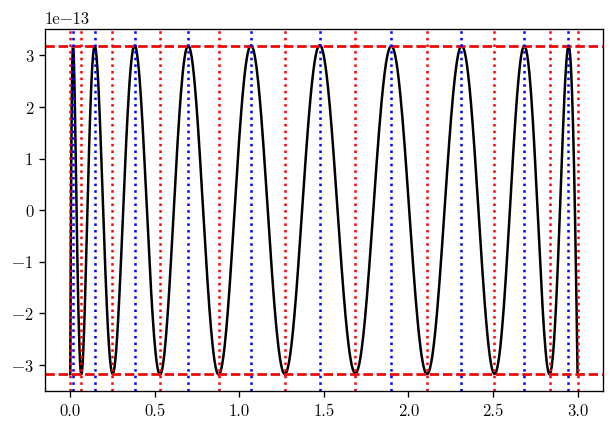

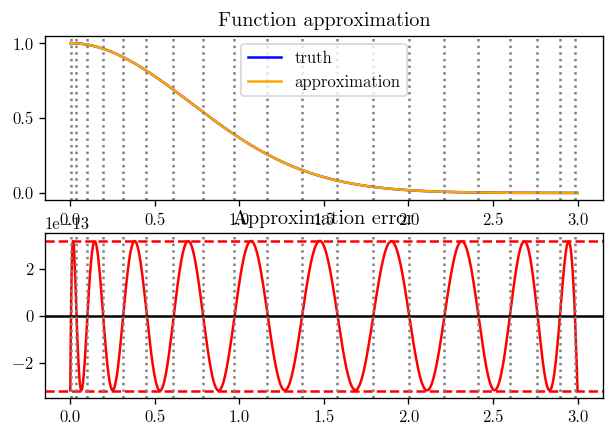

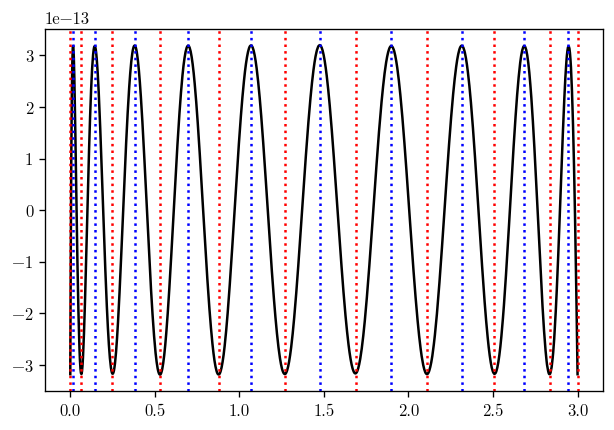

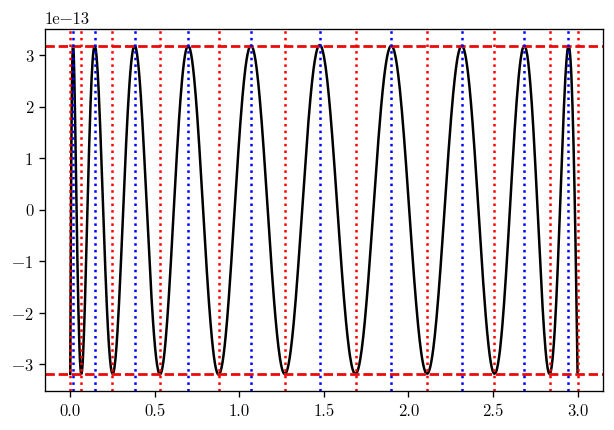

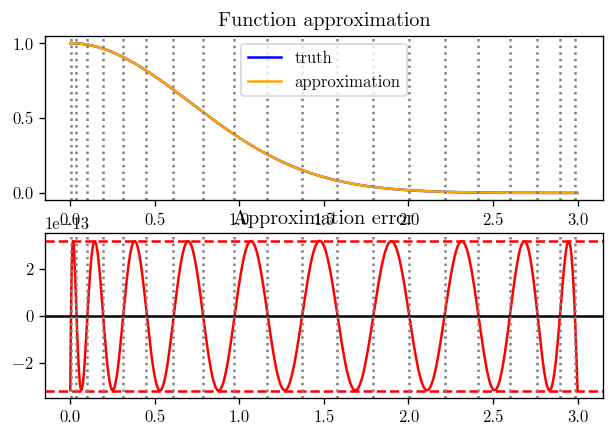

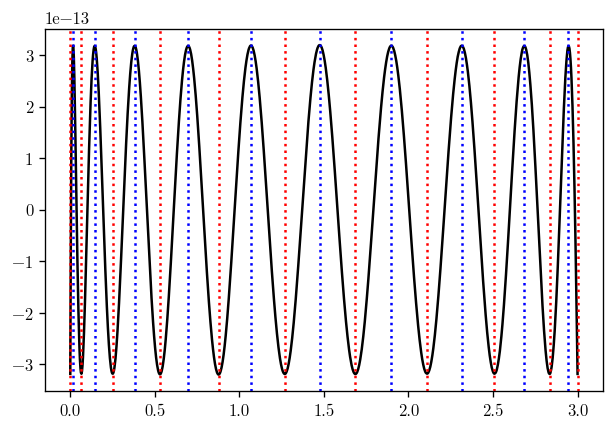

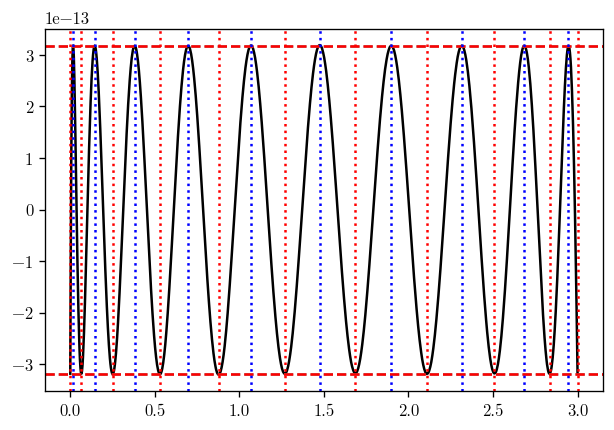

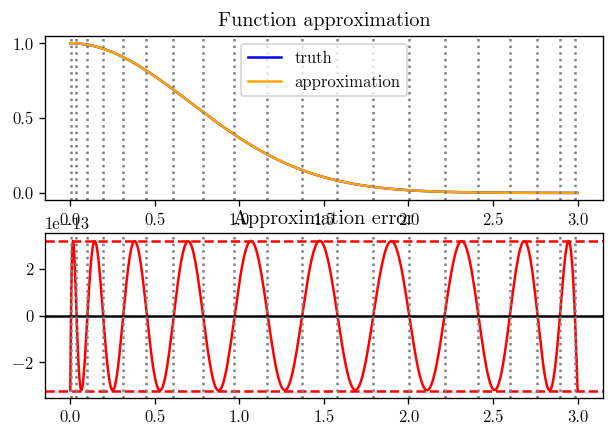

In [301]:
approx_pade(f, start, stop, (12, 9), plot=True)

Starting error 0.020148429421139258, result error -0.01496454198483459
Starting error 0.002591943718152334, result error 0.002698733553159886
Starting error 0.00264533863565611, result error 0.0025841273444880326
Starting error 0.002614732990072071, result error 0.002649731212001096
Starting error 0.0026322321010365836, result error 0.0026121927029809484
Starting error 0.002622212402008766, result error 0.002633677210306138
Starting error 0.002627944806157452, result error 0.0026213825496422113
Starting error 0.002624663677899832, result error 0.002628418788863228
Starting error 0.00262654123338153, result error 0.002624392120472159
Starting error 0.0026254666769268444, result error 0.0026266965418664362
Starting error 0.0026260816093966405, result error 0.0026253777636135785
Starting error 0.0026257296865051095, result error 0.0026261324824322333
Starting error 0.0026259310844686714, result error 0.002625700569144538
Starting error 0.0026258158268066046, result error 0.002625947746741

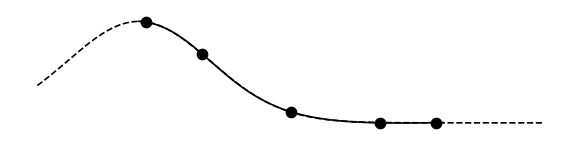

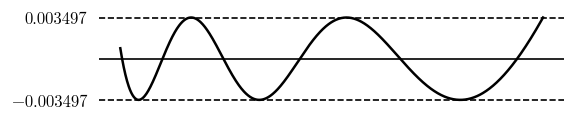

In [241]:
fig, ax = plt.subplots()

xt = np.linspace(-1.0, 4.0, 1000)
yt = f(xt)
ax.plot(xt, yt, linewidth=1.0, color='black', linestyle='dashed')
ax.set_aspect('equal', 'box')


ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)
    
x = chebyshev_nodes(start, stop, np.sum(n) - 1)
y = f(x)
c = approx_pade(f, start, stop, (3, 3), plot=False)
fi = lambda x: evaluate_pade(c, x)
ax.scatter(x, y, color='black')

xt = np.linspace(0, 3, 1000)
ax.plot(xt, fi(xt), linewidth=1.0, color='black', linestyle='solid')

ax.set_ylim([-0.1, 1.1])
fig.savefig(f'ratfn-remez-{n[0]}-{n[1]}.png')


fig, ax = plt.subplots(figsize=(5,1))

e = fi(xt) - f(xt)
ax.plot(xt, e, linewidth=1.5, color='black', linestyle='solid')

ax.axhline(0, color='black', linewidth=1.0, linestyle='solid')
ax.axhline(np.min(e), color='black', linewidth=1.0, linestyle='dashed')
ax.axhline(np.max(e), color='black', linewidth=1.0, linestyle='dashed')

ax.get_yaxis().set_ticks([np.min(e),np.max(e)])
ax.tick_params(axis="y", left=False)

ax.get_yaxis().set_visible(True)
ax.get_xaxis().set_visible(False)
for s in ['top', 'right', 'left', 'bottom']:
    ax.spines[s].set_visible(False)

fig.savefig(f'ratfn-remez-{n[0]}-{n[1]}-err.png')


In [248]:
0.020148429421139258 / 0.003496885403197404

5.761821477683079

In [249]:
 0.026397680609342722 /  0.003496885403197404

7.548912121971683

In [1286]:
white = np.ones(3)
x = np.linspace(start, stop, 1000)
# plt.plot(x, f(x), color='black', label='$e^{-x^2}$')
e_remez_pade = []
for i in range(1, 21):
    errs = []
    for j in range(0, i):
        n = (i - j, j + 1)
        try:
            c = approx_pade(f, start, stop, n, plot=False)
        except BaseException:
            print(f'{i} {n} failed')
            continue
        fi = lambda x: evaluate_pade(c, x)
        err = max_error(start, stop, f, fi)
        print(f'{i} {n} {err}')
        # plt.plot(x, fi(x), label=f'$P_{i,j}(x)$', color=(0.9 - 0.03 * i) * white)
        errs += [err]
    e_remez_pade += [np.min(errs)]

1 (1, 1) 0.49993829509795673
2 (2, 1) 0.2050539934588675
2 (1, 2) failed
3 (3, 1) 0.07768427175033546
3 (2, 2) 0.1085391386635703
3 (1, 3) failed
4 (4, 1) 0.06180797168336705
4 (3, 2) 0.06744001602306438
4 (2, 3) failed
4 (1, 4) failed
5 (5, 1) 0.02076612047545199
5 (4, 2) failed
5 (3, 3) 0.0034968902679068416
5 (2, 4) failed
5 (1, 5) failed
6 (6, 1) 0.00477557895876124
6 (5, 2) 0.00903090781983608
Error: error negative
6 (4, 3) 0.003195272284566329
Error: error negative
6 (3, 4) 0.0032066806823954834
Error: resulting rational function has poles
Remez failed after 0
6 (2, 5) 0.16609120961558455
6 (1, 6) failed
7 (7, 1) 0.003650003926009307
7 (6, 2) 0.0038905979567497306
Error: error negative
Remez failed after 1
7 (5, 3) 0.00518136475912967
Error: resulting rational function has poles
Remez failed after 0
7 (4, 4) 0.005403056815457163
Error: error negative
Error: resulting rational function has poles
Remez failed after 0
7 (3, 5) 0.013371283509107323
Error: error negative
Remez failed 

## Comparisson

In [1343]:
np.log10(100)

2.0

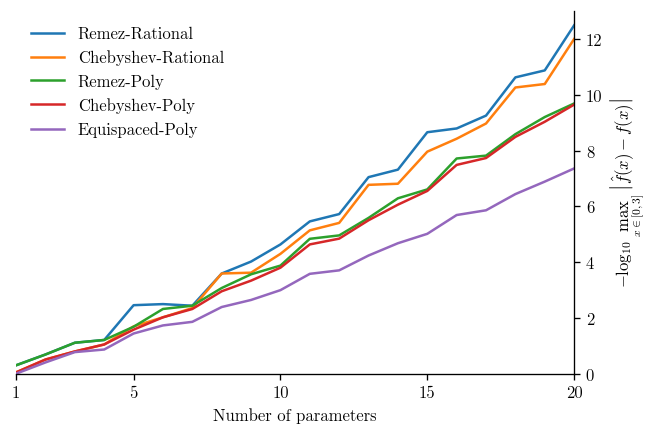

In [1372]:
fig, ax = plt.subplots()

ax.plot(range(1,21), -np.log10(e_remez_pade), label='Remez-Rational')
ax.plot(range(1,21), -np.log10(e_pade), label='Chebyshev-Rational')
ax.plot(range(1,21), -np.log10(e_remez), label='Remez-Poly')
ax.plot(range(1,21), -np.log10(e_chebyshev), label='Chebyshev-Poly')
ax.plot(range(1,21), -np.log10(e_equispaced), label='Equispaced-Poly')

ax.set_xticks([1,5,10,15,20])
ax.set_xlim([1,20])
ax.set_ylim([0, 13])
ax.set_xlabel('Number of parameters')
ax.set_ylabel(r'$-\log_{10}\; \max_{x\in[0,3]}\; \left\vert \hat{f}(x) - f(x) \right\vert$', rotation=90)
ax.legend(frameon=False)
for s in ['top', 'left']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

fig.savefig('convergence.png')

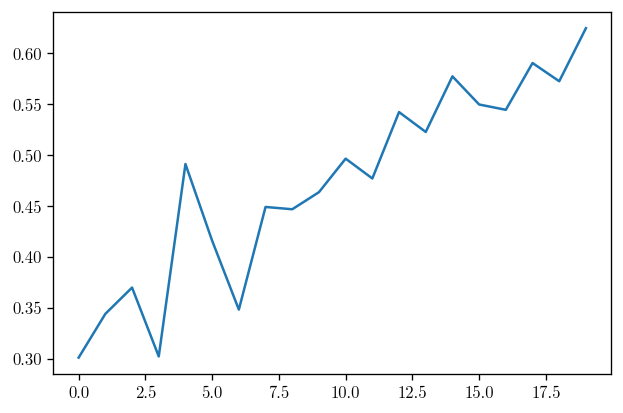

In [1363]:
plt.plot(-np.log10(np.array(e_remez_pade)) / np.array(range(1,21)))

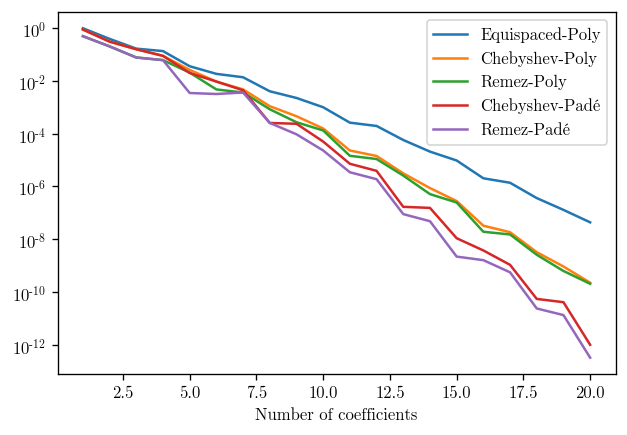

In [1155]:
plt.plot(range(1,21), e_equispaced, label='Equispaced-Poly')
plt.plot(range(1,21), e_chebyshev, label='Chebyshev-Poly')
plt.plot(range(1,21), e_remez, label='Remez-Poly')
plt.plot(range(1,21), e_pade, label='Chebyshev-Padé')
plt.plot(range(1,21), e_remez_pade, label='Remez-Padé')

plt.yscale('log')
plt.xlabel('Number of coefficients')
plt.legend()